In [1]:
# Import Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure plotting settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")


✅ Libraries imported successfully!
Pandas version: 2.3.0
NumPy version: 2.3.0
Matplotlib version: 3.10.3
Seaborn version: 0.13.2


In [2]:
# Load the dataset
data_path = 'postings.csv'

try:
    df = pd.read_csv(data_path)
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Shape: {df.shape[0]} rows, {df.shape[1]} columns")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except FileNotFoundError:
    print(f"❌ Error: Could not find {data_path}")
    print("Please ensure the dataset is in the correct location.")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")


✅ Dataset loaded successfully!
📊 Shape: 9380 rows, 11 columns
💾 Memory usage: 70.15 MB


In [3]:
# Initial Data Exploration
print("🔍 INITIAL DATA EXPLORATION")
print("=" * 50)

# Display basic information
print(f"\n📋 Dataset Info:")
print(f"Columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")

print(f"\n📊 Basic Statistics:")
df.info()

print(f"\n📝 First few rows:")
df.head()


🔍 INITIAL DATA EXPLORATION

📋 Dataset Info:
Columns: ['job_title', 'company', 'job_location', 'job_link', 'first_seen', 'search_city', 'search_country', 'job level', 'job_type', 'job_summary', 'job_skills']
Data types:
job_title         object
company           object
job_location      object
job_link          object
first_seen        object
search_city       object
search_country    object
job level         object
job_type          object
job_summary       object
job_skills        object
dtype: object

📊 Basic Statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9380 entries, 0 to 9379
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   job_title       9380 non-null   object
 1   company         9380 non-null   object
 2   job_location    9380 non-null   object
 3   job_link        9380 non-null   object
 4   first_seen      9380 non-null   object
 5   search_city     9380 non-null   object
 6   search_

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,job_skills
0,C# Software Engineer,E Tech Group,"West Chester, OH",https://www.linkedin.com/jobs/view/c%23-softwa...,2023-12-25,Covington,United States,Associate,Remote,"At E Tech Group, joining our team means joinin...","C#, .NET, WPF, ASP.NET MVC, WebAPI, C++, Progr..."
1,Software Implementation Engineer,Kardex,"Cincinnati, OH",https://www.linkedin.com/jobs/view/software-im...,2023-12-25,Covington,United States,Associate,Remote,Kardex Remstar is looking for a\nSoftware Impl...,"Software Implementation, Software Testing, Sof..."
2,"Senior Software Engineer, Back End (Go, AWS, J...",Jobs for Humanity,"Chattanooga, TN",https://www.linkedin.com/jobs/view/senior-soft...,2023-12-25,Chattanooga,United States,Mid senior,Onsite,Company Description\nJobs for Humanity is part...,"Java, Python, SQL, Node.js, Go, Scala, AWS, GC..."
3,"Senior Manager, Software Engineering, Full Stack",Jobs for Humanity,"Chattanooga, TN",https://www.linkedin.com/jobs/view/senior-mana...,2023-12-25,Chattanooga,United States,Mid senior,Onsite,Company Description\nJobs for Humanity is part...,"JavaScript, Java, TypeScript, SQL, Python, Go,..."
4,"Lead Software Engineer, Full Stack(JavaScript/...",Jobs for Humanity,"Chattanooga, TN",https://www.linkedin.com/jobs/view/lead-softwa...,2023-12-25,Chattanooga,United States,Mid senior,Onsite,Company Description\nJobs for Humanity is part...,"JavaScript, Java, AWS, Vue.js, HTML/CSS, TypeS..."


🔍 MISSING VALUES ANALYSIS
Missing Data Summary:
         Column  Missing_Count  Missing_Percentage
10   job_skills             13            0.138593
9   job_summary              4            0.042644


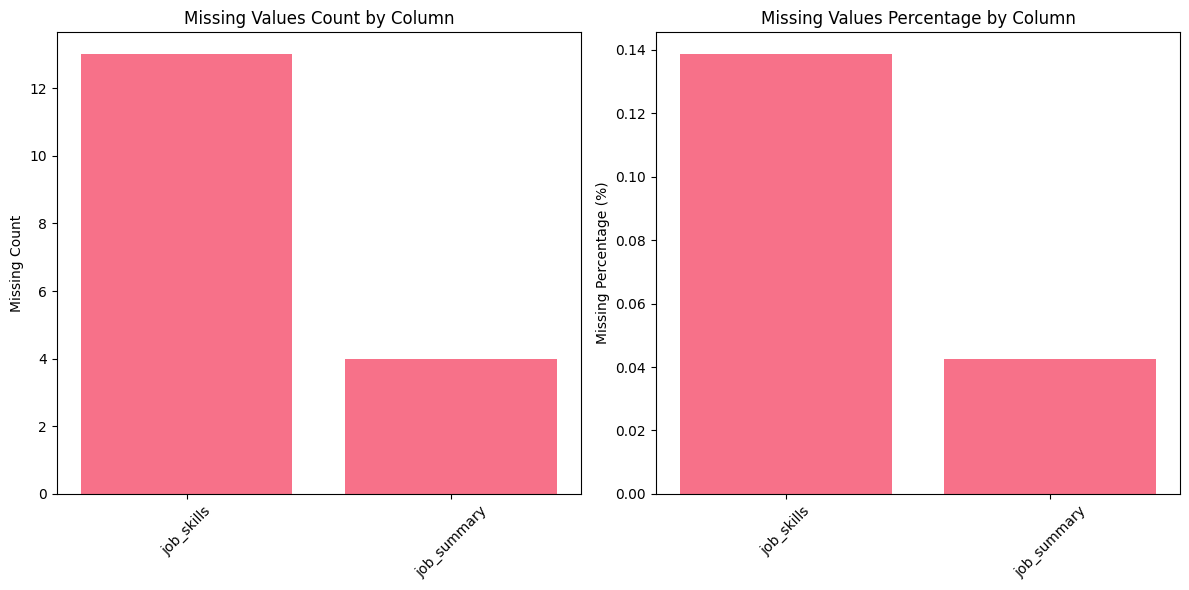

In [4]:
# Missing Values Analysis - Critical for AI Engineers
print("🔍 MISSING VALUES ANALYSIS")
print("=" * 50)

# Calculate missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

# Create a comprehensive missing data report
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
}).sort_values('Missing_Count', ascending=False)

# Display missing data summary
print("Missing Data Summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

# Visualize missing data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
missing_counts = missing_df[missing_df['Missing_Count'] > 0]
if not missing_counts.empty:
    plt.bar(missing_counts['Column'], missing_counts['Missing_Count'])
    plt.title('Missing Values Count by Column')
    plt.xticks(rotation=45)
    plt.ylabel('Missing Count')
    
    plt.subplot(1, 2, 2)
    plt.bar(missing_counts['Column'], missing_counts['Missing_Percentage'])
    plt.title('Missing Values Percentage by Column')
    plt.xticks(rotation=45)
    plt.ylabel('Missing Percentage (%)')
else:
    plt.text(0.5, 0.5, 'No Missing Values Found!', ha='center', va='center', fontsize=16)
    plt.title('Missing Values Analysis')

plt.tight_layout()
plt.show()


In [5]:
# Create a preprocessing pipeline
def preprocess_job_data(df):
    """
    Comprehensive preprocessing pipeline for job postings data
    
    Args:
        df: Raw DataFrame
    
    Returns:
        processed_df: Cleaned and feature-engineered DataFrame
    """
    print("🔧 STARTING DATA PREPROCESSING PIPELINE")
    print("=" * 50)
    
    # Create a copy to avoid modifying original data
    processed_df = df.copy()
    initial_shape = processed_df.shape
    
    # 1. Handle missing values strategically
    print("1️⃣ Handling missing values...")
    
    # For text fields, fill with meaningful defaults
    processed_df['job_summary'] = processed_df['job_summary'].fillna('No description available')
    processed_df['job_skills'] = processed_df['job_skills'].fillna('Not specified')
    
    # For other fields, use forward fill or mode
    processed_df['company'] = processed_df['company'].fillna('Unknown Company')
    processed_df['job_location'] = processed_df['job_location'].fillna('Location not specified')
    
    print(f"   ✅ Missing values handled")
    
    # 2. Data type conversions
    print("2️⃣ Converting data types...")
    
    # Convert date columns
    processed_df['first_seen'] = pd.to_datetime(processed_df['first_seen'], errors='coerce')
    
    # Clean and standardize text fields
    text_columns = ['job_title', 'company', 'job_location', 'job_summary', 'job_skills']
    for col in text_columns:
        if col in processed_df.columns:
            processed_df[col] = processed_df[col].astype(str).str.strip()
    
    print(f"   ✅ Data types converted")
    
    # 3. Feature engineering
    print("3️⃣ Creating derived features...")
    
    # Text length features
    processed_df['title_length'] = processed_df['job_title'].str.len()
    processed_df['summary_length'] = processed_df['job_summary'].str.len()
    
    # Boolean features
    processed_df['is_remote'] = processed_df['job_type'].str.contains('Remote', case=False, na=False)
    processed_df['is_senior'] = processed_df['job_title'].str.contains('Senior|Lead|Principal|Sr\.', case=False, na=False)
    processed_df['is_junior'] = processed_df['job_title'].str.contains('Junior|Jr\.|Entry|Intern', case=False, na=False)
    
    # Skills processing
    def extract_skills_count(skills_str):
        """Extract number of skills from skills string"""
        if pd.isna(skills_str) or skills_str == 'Not specified':
            return 0
        # Split by common delimiters
        skills = re.split(r'[,;|]', str(skills_str))
        return len([skill.strip() for skill in skills if skill.strip()])
    
    processed_df['skills_count'] = processed_df['job_skills'].apply(extract_skills_count)
    
    # Location processing
    def extract_location_parts(location_str):
        """Extract city and state from location string"""
        if pd.isna(location_str) or location_str == 'Location not specified':
            return 'Unknown', 'Unknown'
        
        parts = str(location_str).split(', ')
        city = parts[0].strip() if len(parts) > 0 else 'Unknown'
        state = parts[1].strip() if len(parts) > 1 else 'Unknown'
        return city, state
    
    processed_df[['city', 'state']] = processed_df['job_location'].apply(
        lambda x: pd.Series(extract_location_parts(x))
    )
    
    # Date features
    processed_df['posting_year'] = processed_df['first_seen'].dt.year
    processed_df['posting_month'] = processed_df['first_seen'].dt.month
    processed_df['posting_day_of_week'] = processed_df['first_seen'].dt.day_name()
    
    print(f"   ✅ Features engineered")
    
    # 4. Data validation and cleaning
    print("4️⃣ Validating and cleaning data...")
    
    # Remove duplicates
    initial_rows = len(processed_df)
    processed_df = processed_df.drop_duplicates()
    duplicates_removed = initial_rows - len(processed_df)
    
    # Remove rows with missing critical information
    processed_df = processed_df.dropna(subset=['job_title', 'company'])
    
    print(f"   ✅ Removed {duplicates_removed} duplicate rows")
    print(f"   ✅ Data validation completed")
    
    final_shape = processed_df.shape
    print(f"\n📊 PREPROCESSING SUMMARY:")
    print(f"   Initial shape: {initial_shape}")
    print(f"   Final shape: {final_shape}")
    print(f"   Rows removed: {initial_shape[0] - final_shape[0]}")
    print(f"   Features added: {final_shape[1] - initial_shape[1]}")
    
    return processed_df

# Apply preprocessing pipeline
processed_df = preprocess_job_data(df)


🔧 STARTING DATA PREPROCESSING PIPELINE
1️⃣ Handling missing values...
   ✅ Missing values handled
2️⃣ Converting data types...
   ✅ Data types converted
3️⃣ Creating derived features...
   ✅ Features engineered
4️⃣ Validating and cleaning data...
   ✅ Removed 0 duplicate rows
   ✅ Data validation completed

📊 PREPROCESSING SUMMARY:
   Initial shape: (9380, 11)
   Final shape: (9380, 22)
   Rows removed: 0
   Features added: 11


In [6]:
# Inspect the preprocessed data
print("🔍 PREPROCESSED DATA INSPECTION")
print("=" * 50)

print("\nNew columns created:")
new_columns = [col for col in processed_df.columns if col not in df.columns]
for col in new_columns:
    print(f"  • {col}")

print(f"\nData types after preprocessing:")
print(processed_df.dtypes)

print(f"\nSample of processed data:")
processed_df.head()


🔍 PREPROCESSED DATA INSPECTION

New columns created:
  • title_length
  • summary_length
  • is_remote
  • is_senior
  • is_junior
  • skills_count
  • city
  • state
  • posting_year
  • posting_month
  • posting_day_of_week

Data types after preprocessing:
job_title                      object
company                        object
job_location                   object
job_link                       object
first_seen             datetime64[ns]
search_city                    object
search_country                 object
job level                      object
job_type                       object
job_summary                    object
job_skills                     object
title_length                    int64
summary_length                  int64
is_remote                        bool
is_senior                        bool
is_junior                        bool
skills_count                    int64
city                           object
state                          object
posting_year       

,job_title,company,job_location,job_link,first_seen,search_city,search_country,job level,job_type,job_summary,...,summary_length,is_remote,is_senior,is_junior,skills_count,city,state,posting_year,posting_month,posting_day_of_week
0,C# Software Engineer,E Tech Group,"West Chester, OH",https://www.linkedin.com/jobs/view/c%23-softwa...,2023-12-25,Covington,United States,Associate,Remote,"At E Tech Group, joining our team means joinin...",...,3124,True,False,False,18,West Chester,OH,2023,12,Monday
1,Software Implementation Engineer,Kardex,"Cincinnati, OH",https://www.linkedin.com/jobs/view/software-im...,2023-12-25,Covington,United States,Associate,Remote,Kardex Remstar is looking for a\nSoftware Impl...,...,1984,True,False,False,24,Cincinnati,OH,2023,12,Monday
2,"Senior Software Engineer, Back End (Go, AWS, J...",Jobs for Humanity,"Chattanooga, TN",https://www.linkedin.com/jobs/view/senior-soft...,2023-12-25,Chattanooga,United States,Mid senior,Onsite,Company Description\nJobs for Humanity is part...,...,3423,False,True,False,13,Chattanooga,TN,2023,12,Monday
3,"Senior Manager, Software Engineering, Full Stack",Jobs for Humanity,"Chattanooga, TN",https://www.linkedin.com/jobs/view/senior-mana...,2023-12-25,Chattanooga,United States,Mid senior,Onsite,Company Description\nJobs for Humanity is part...,...,2795,False,True,False,11,Chattanooga,TN,2023,12,Monday
4,"Lead Software Engineer, Full Stack(JavaScript/...",Jobs for Humanity,"Chattanooga, TN",https://www.linkedin.com/jobs/view/lead-softwa...,2023-12-25,Chattanooga,United States,Mid senior,Onsite,Company Description\nJobs for Humanity is part...,...,4438,False,True,False,14,Chattanooga,TN,2023,12,Monday


📈 CREATING COMPREHENSIVE EDA DASHBOARD


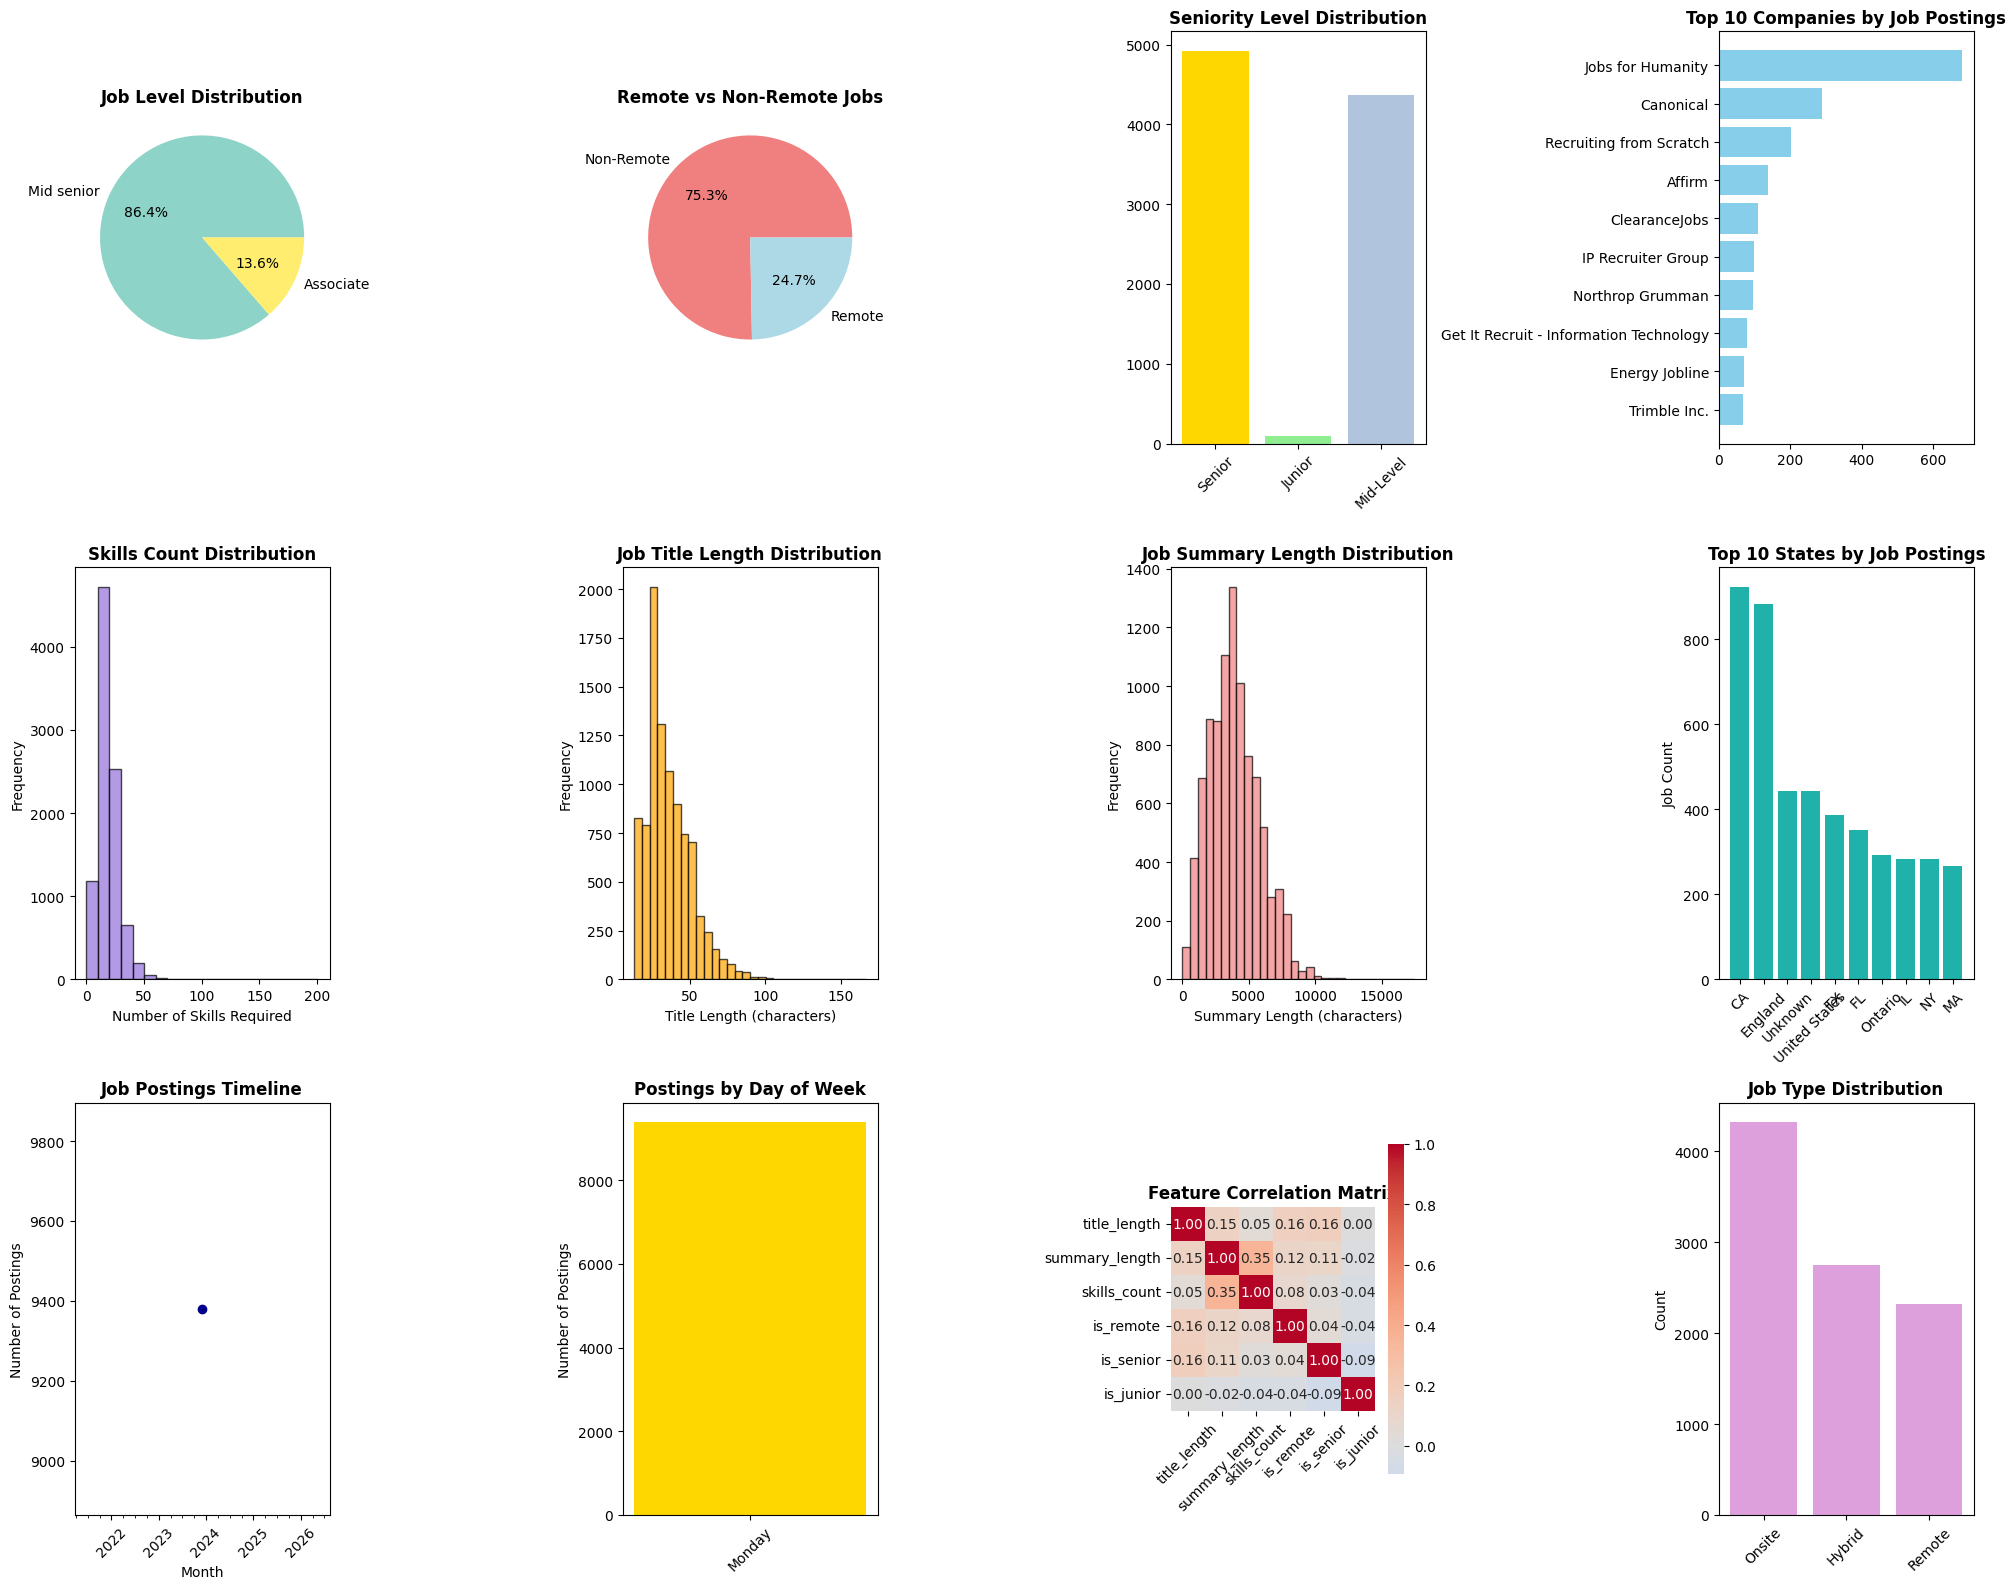

In [7]:
# Comprehensive EDA and Visualization Suite
def create_comprehensive_eda(df):
    """Create a comprehensive EDA dashboard"""
    
    print("📈 CREATING COMPREHENSIVE EDA DASHBOARD")
    print("=" * 50)
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Job Level Distribution
    plt.subplot(3, 4, 1)
    if 'job level' in df.columns:
        job_level_counts = df['job level'].value_counts()
        colors = plt.cm.Set3(np.linspace(0, 1, len(job_level_counts)))
        plt.pie(job_level_counts.values, labels=job_level_counts.index, autopct='%1.1f%%', colors=colors)
        plt.title('Job Level Distribution', fontweight='bold')
    
    # 2. Remote vs Non-Remote Jobs
    plt.subplot(3, 4, 2)
    remote_counts = df['is_remote'].value_counts()
    plt.pie(remote_counts.values, labels=['Non-Remote', 'Remote'], autopct='%1.1f%%', 
            colors=['lightcoral', 'lightblue'])
    plt.title('Remote vs Non-Remote Jobs', fontweight='bold')
    
    # 3. Senior vs Junior Positions
    plt.subplot(3, 4, 3)
    seniority_data = pd.DataFrame({
        'Senior': df['is_senior'].sum(),
        'Junior': df['is_junior'].sum(),
        'Mid-Level': len(df) - df['is_senior'].sum() - df['is_junior'].sum()
    }, index=[0]).T
    
    plt.bar(seniority_data.index, seniority_data[0], color=['gold', 'lightgreen', 'lightsteelblue'])
    plt.title('Seniority Level Distribution', fontweight='bold')
    plt.xticks(rotation=45)
    
    # 4. Top 10 Companies
    plt.subplot(3, 4, 4)
    top_companies = df['company'].value_counts().head(10)
    plt.barh(range(len(top_companies)), top_companies.values, color='skyblue')
    plt.yticks(range(len(top_companies)), top_companies.index)
    plt.title('Top 10 Companies by Job Postings', fontweight='bold')
    plt.gca().invert_yaxis()
    
    # 5. Skills Count Distribution
    plt.subplot(3, 4, 5)
    plt.hist(df['skills_count'], bins=20, alpha=0.7, color='mediumpurple', edgecolor='black')
    plt.title('Skills Count Distribution', fontweight='bold')
    plt.xlabel('Number of Skills Required')
    plt.ylabel('Frequency')
    
    # 6. Job Title Length Distribution
    plt.subplot(3, 4, 6)
    plt.hist(df['title_length'], bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.title('Job Title Length Distribution', fontweight='bold')
    plt.xlabel('Title Length (characters)')
    plt.ylabel('Frequency')
    
    # 7. Job Summary Length Distribution
    plt.subplot(3, 4, 7)
    plt.hist(df['summary_length'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title('Job Summary Length Distribution', fontweight='bold')
    plt.xlabel('Summary Length (characters)')
    plt.ylabel('Frequency')
    
    # 8. Top States/Locations
    plt.subplot(3, 4, 8)
    top_states = df['state'].value_counts().head(10)
    plt.bar(range(len(top_states)), top_states.values, color='lightseagreen')
    plt.xticks(range(len(top_states)), top_states.index, rotation=45)
    plt.title('Top 10 States by Job Postings', fontweight='bold')
    plt.ylabel('Job Count')
    
    # 9. Posting Timeline
    plt.subplot(3, 4, 9)
    if df['first_seen'].notna().any():
        monthly_posts = df.groupby(df['first_seen'].dt.to_period('M')).size()
        monthly_posts.plot(kind='line', color='darkblue', marker='o')
        plt.title('Job Postings Timeline', fontweight='bold')
        plt.xlabel('Month')
        plt.ylabel('Number of Postings')
        plt.xticks(rotation=45)
    
    # 10. Day of Week Distribution
    plt.subplot(3, 4, 10)
    if 'posting_day_of_week' in df.columns:
        day_counts = df['posting_day_of_week'].value_counts()
        # Reorder by weekday
        weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_counts = day_counts.reindex([day for day in weekday_order if day in day_counts.index])
        plt.bar(day_counts.index, day_counts.values, color='gold')
        plt.title('Postings by Day of Week', fontweight='bold')
        plt.xticks(rotation=45)
        plt.ylabel('Number of Postings')
    
    # 11. Correlation Heatmap
    plt.subplot(3, 4, 11)
    numeric_cols = ['title_length', 'summary_length', 'skills_count', 'is_remote', 'is_senior', 'is_junior']
    numeric_cols = [col for col in numeric_cols if col in df.columns]
    
    if len(numeric_cols) > 1:
        correlation_matrix = df[numeric_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('Feature Correlation Matrix', fontweight='bold')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
    
    # 12. Job Type Distribution
    plt.subplot(3, 4, 12)
    if 'job_type' in df.columns:
        job_type_counts = df['job_type'].value_counts().head(8)
        plt.bar(range(len(job_type_counts)), job_type_counts.values, color='plum')
        plt.xticks(range(len(job_type_counts)), job_type_counts.index, rotation=45)
        plt.title('Job Type Distribution', fontweight='bold')
        plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Create the comprehensive EDA
eda_fig = create_comprehensive_eda(processed_df)


In [8]:
# Advanced Analytics and Insights Generation
def generate_data_insights(df):
    """Generate comprehensive insights from the job postings data"""
    
    print("🧠 GENERATING DATA INSIGHTS")
    print("=" * 50)
    
    insights = []
    
    # 1. Overall dataset insights
    total_jobs = len(df)
    total_companies = df['company'].nunique()
    total_locations = df['city'].nunique()
    
    insights.append(f"📊 Dataset Overview:")
    insights.append(f"   • Total job postings: {total_jobs:,}")
    insights.append(f"   • Unique companies: {total_companies:,}")
    insights.append(f"   • Unique locations: {total_locations:,}")
    
    # 2. Remote work trends
    remote_percentage = (df['is_remote'].sum() / len(df)) * 100
    insights.append(f"\n🏠 Remote Work Analysis:")
    insights.append(f"   • {remote_percentage:.1f}% of jobs offer remote work")
    
    # 3. Seniority analysis
    senior_percentage = (df['is_senior'].sum() / len(df)) * 100
    junior_percentage = (df['is_junior'].sum() / len(df)) * 100
    insights.append(f"\n👔 Seniority Level Analysis:")
    insights.append(f"   • Senior positions: {senior_percentage:.1f}%")
    insights.append(f"   • Junior positions: {junior_percentage:.1f}%")
    insights.append(f"   • Mid-level positions: {100 - senior_percentage - junior_percentage:.1f}%")
    
    # 4. Skills analysis
    avg_skills = df['skills_count'].mean()
    max_skills = df['skills_count'].max()
    min_skills = df['skills_count'].min()
    insights.append(f"\n🛠️ Skills Requirements Analysis:")
    insights.append(f"   • Average skills per job: {avg_skills:.1f}")
    insights.append(f"   • Maximum skills required: {max_skills}")
    insights.append(f"   • Minimum skills required: {min_skills}")
    
    # 5. Geographic insights
    top_location = df['state'].value_counts().iloc[0]
    top_location_name = df['state'].value_counts().index[0]
    insights.append(f"\n🗺️ Geographic Analysis:")
    insights.append(f"   • Top hiring state: {top_location_name} ({top_location} jobs)")
    
    # 6. Company insights
    top_employer = df['company'].value_counts().iloc[0]
    top_employer_name = df['company'].value_counts().index[0]
    insights.append(f"\n🏢 Company Analysis:")
    insights.append(f"   • Top employer: {top_employer_name} ({top_employer} jobs)")
    
    # 7. Text analysis insights
    avg_title_length = df['title_length'].mean()
    avg_summary_length = df['summary_length'].mean()
    insights.append(f"\n📝 Content Analysis:")
    insights.append(f"   • Average job title length: {avg_title_length:.0f} characters")
    insights.append(f"   • Average job summary length: {avg_summary_length:.0f} characters")
    
    # 8. Temporal insights
    if 'posting_year' in df.columns and df['posting_year'].notna().any():
        posting_years = df['posting_year'].value_counts().sort_index()
        peak_year = posting_years.idxmax()
        peak_count = posting_years.max()
        insights.append(f"\n📅 Temporal Analysis:")
        insights.append(f"   • Peak posting year: {peak_year} ({peak_count} jobs)")
    
    # Print all insights
    for insight in insights:
        print(insight)
    
    return insights

# Generate insights
insights = generate_data_insights(processed_df)


🧠 GENERATING DATA INSIGHTS
📊 Dataset Overview:
   • Total job postings: 9,380
   • Unique companies: 3,373
   • Unique locations: 1,452

🏠 Remote Work Analysis:
   • 24.7% of jobs offer remote work

👔 Seniority Level Analysis:
   • Senior positions: 52.5%
   • Junior positions: 1.0%
   • Mid-level positions: 46.5%

🛠️ Skills Requirements Analysis:
   • Average skills per job: 19.4
   • Maximum skills required: 201
   • Minimum skills required: 0

🗺️ Geographic Analysis:
   • Top hiring state: CA (924 jobs)

🏢 Company Analysis:
   • Top employer: Jobs for Humanity (681 jobs)

📝 Content Analysis:
   • Average job title length: 36 characters
   • Average job summary length: 3926 characters

📅 Temporal Analysis:
   • Peak posting year: 2023 (9380 jobs)


🛠️ SKILLS ANALYSIS
Total unique skills found: 27763
Top 20 most in-demand skills:


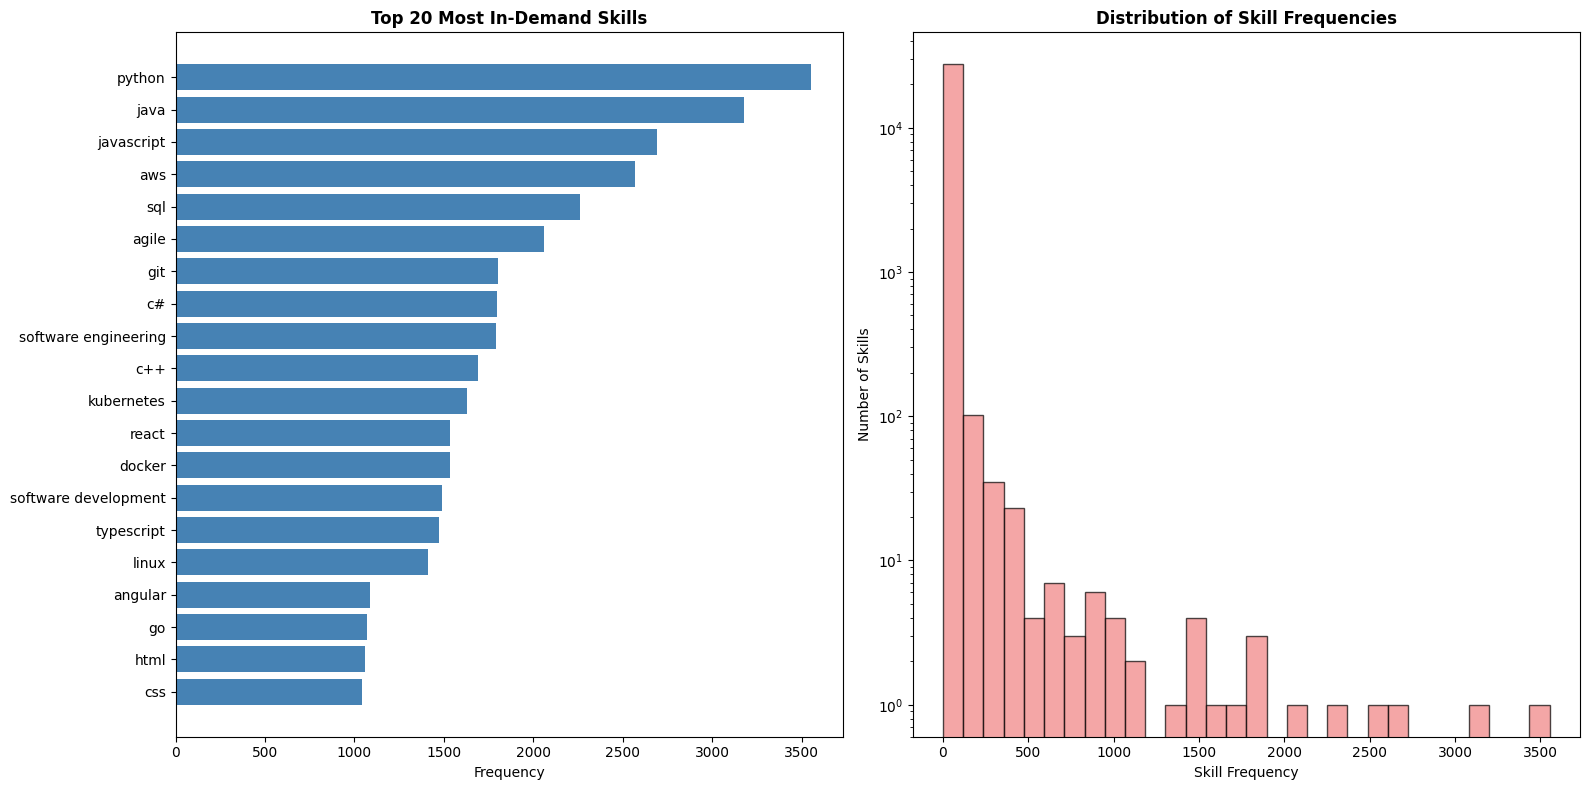

 1. Python: 3554 jobs (37.9%)
 2. Java: 3181 jobs (33.9%)
 3. Javascript: 2691 jobs (28.7%)
 4. Aws: 2569 jobs (27.4%)
 5. Sql: 2263 jobs (24.1%)
 6. Agile: 2059 jobs (22.0%)
 7. Git: 1803 jobs (19.2%)
 8. C#: 1796 jobs (19.1%)
 9. Software Engineering: 1791 jobs (19.1%)
10. C++: 1690 jobs (18.0%)


In [9]:
# Skills Analysis - Extract and analyze the most in-demand skills
def analyze_skills(df):
    """Analyze and visualize the most in-demand skills"""
    
    print("🛠️ SKILLS ANALYSIS")
    print("=" * 50)
    
    # Extract all individual skills
    all_skills = []
    for skills_str in df['job_skills'].dropna():
        if skills_str != 'Not specified':
            skills = re.split(r'[,;|]', str(skills_str))
            all_skills.extend([skill.strip().lower() for skill in skills if skill.strip()])
    
    # Count skill frequencies
    skill_counts = Counter(all_skills)
    top_skills = skill_counts.most_common(20)
    
    print(f"Total unique skills found: {len(skill_counts)}")
    print(f"Top 20 most in-demand skills:")
    
    # Create skills visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Top skills bar chart
    skills_names = [skill[0] for skill in top_skills]
    skills_counts = [skill[1] for skill in top_skills]
    
    ax1.barh(range(len(skills_names)), skills_counts, color='steelblue')
    ax1.set_yticks(range(len(skills_names)))
    ax1.set_yticklabels(skills_names)
    ax1.set_xlabel('Frequency')
    ax1.set_title('Top 20 Most In-Demand Skills', fontweight='bold')
    ax1.invert_yaxis()
    
    # Skills distribution
    skill_frequency_dist = list(skill_counts.values())
    ax2.hist(skill_frequency_dist, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    ax2.set_xlabel('Skill Frequency')
    ax2.set_ylabel('Number of Skills')
    ax2.set_title('Distribution of Skill Frequencies', fontweight='bold')
    ax2.set_yscale('log')  # Log scale for better visualization
    
    plt.tight_layout()
    plt.show()
    
    # Print top skills
    for i, (skill, count) in enumerate(top_skills[:10], 1):
        print(f"{i:2d}. {skill.title()}: {count} jobs ({count/len(df)*100:.1f}%)")
    
    return skill_counts, top_skills

# Analyze skills
skill_counts, top_skills = analyze_skills(processed_df)


📊 STATISTICAL ANALYSIS
📈 Descriptive Statistics:
       title_length  summary_length  skills_count
count   9380.000000     9380.000000   9380.000000
mean      35.823667     3925.559915     19.385394
std       14.877702     1894.096807      9.439172
min       13.000000       24.000000      0.000000
25%       24.000000     2525.000000     13.000000
50%       33.000000     3796.500000     18.000000
75%       45.000000     5094.250000     24.000000
max      167.000000    17433.000000    201.000000


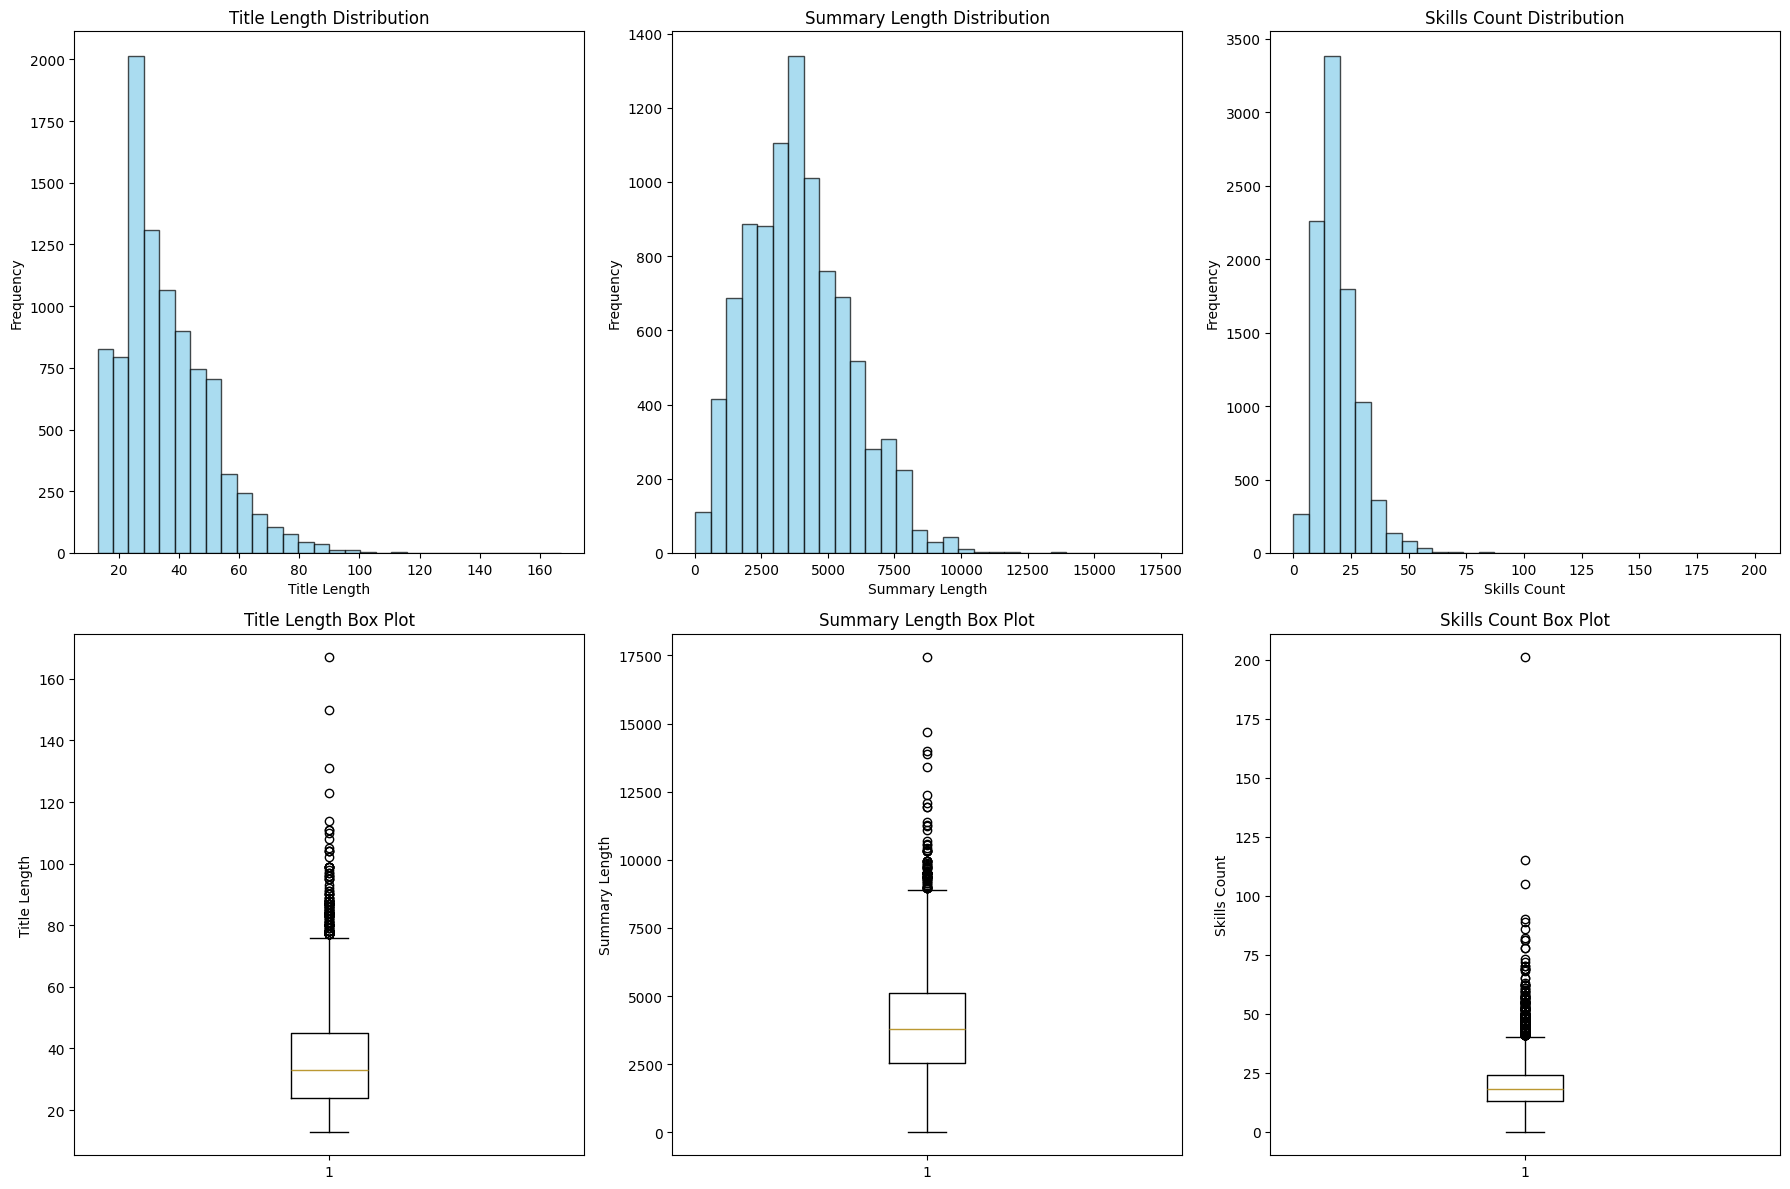

\n🎯 Outlier Analysis:
   title_length: 157 outliers (1.7%)
      Range: [-7.5, 76.5]
   summary_length: 85 outliers (0.9%)
      Range: [-1328.9, 8948.1]
   skills_count: 284 outliers (3.0%)
      Range: [-3.5, 40.5]
\n📊 Distribution Analysis:
   title_length:
      Skewness: 1.248 (Right-skewed)
      Kurtosis: 2.537 (Heavy-tailed)
   summary_length:
      Skewness: 0.585 (Right-skewed)
      Kurtosis: 0.580 (Heavy-tailed)
   skills_count:
      Skewness: 2.258 (Right-skewed)
      Kurtosis: 19.920 (Heavy-tailed)


In [10]:
# Statistical Analysis and Data Quality Assessment
def perform_statistical_analysis(df):
    """Perform comprehensive statistical analysis"""
    
    print("📊 STATISTICAL ANALYSIS")
    print("=" * 50)
    
    # Select numeric columns for analysis
    numeric_cols = ['title_length', 'summary_length', 'skills_count']
    numeric_cols = [col for col in numeric_cols if col in df.columns]
    
    if not numeric_cols:
        print("No numeric columns found for analysis")
        return
    
    # Descriptive statistics
    print("📈 Descriptive Statistics:")
    print(df[numeric_cols].describe())
    
    # Create statistical visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    for i, col in enumerate(numeric_cols):
        # Histogram
        axes[0, i].hist(df[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, i].set_title(f'{col.replace("_", " ").title()} Distribution')
        axes[0, i].set_xlabel(col.replace("_", " ").title())
        axes[0, i].set_ylabel('Frequency')
        
        # Box plot
        axes[1, i].boxplot(df[col])
        axes[1, i].set_title(f'{col.replace("_", " ").title()} Box Plot')
        axes[1, i].set_ylabel(col.replace("_", " ").title())
    
    plt.tight_layout()
    plt.show()
    
    # Outlier analysis
    print("\\n🎯 Outlier Analysis:")
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_percentage = (len(outliers) / len(df)) * 100
        
        print(f"   {col}: {len(outliers)} outliers ({outlier_percentage:.1f}%)")
        print(f"      Range: [{lower_bound:.1f}, {upper_bound:.1f}]")
    
    # Normality tests (visual)
    print("\\n📊 Distribution Analysis:")
    from scipy import stats
    
    for col in numeric_cols:
        # Skewness and kurtosis
        skewness = stats.skew(df[col])
        kurtosis = stats.kurtosis(df[col])
        
        print(f"   {col}:")
        print(f"      Skewness: {skewness:.3f} ({'Right-skewed' if skewness > 0 else 'Left-skewed' if skewness < 0 else 'Symmetric'})")
        print(f"      Kurtosis: {kurtosis:.3f} ({'Heavy-tailed' if kurtosis > 0 else 'Light-tailed'})")

# Perform statistical analysis
perform_statistical_analysis(processed_df)


In [11]:
# Data Export and ML Preparation
def prepare_for_ml_and_export(df):
    """Prepare data for machine learning and export cleaned dataset"""
    
    print("🚀 PREPARING DATA FOR MACHINE LEARNING")
    print("=" * 50)
    
    # Create ML-ready features
    ml_df = df.copy()
    
    # Encode categorical variables
    print("1️⃣ Encoding categorical variables...")
    
    # Binary encoding for boolean features
    boolean_features = ['is_remote', 'is_senior', 'is_junior']
    for feature in boolean_features:
        if feature in ml_df.columns:
            ml_df[f'{feature}_encoded'] = ml_df[feature].astype(int)
    
    # One-hot encoding for categorical features (top categories only)
    print("2️⃣ One-hot encoding categorical features...")
    
    # Encode top job levels
    if 'job level' in ml_df.columns:
        top_job_levels = ml_df['job level'].value_counts().head(5).index
        for level in top_job_levels:
            ml_df[f'job_level_{level.lower().replace(" ", "_")}'] = (ml_df['job level'] == level).astype(int)
    
    # Encode top states
    top_states = ml_df['state'].value_counts().head(10).index
    for state in top_states:
        ml_df[f'state_{state.lower().replace(" ", "_")}'] = (ml_df['state'] == state).astype(int)
    
    # Feature scaling preparation
    print("3️⃣ Preparing numerical features for scaling...")
    
    numerical_features = ['title_length', 'summary_length', 'skills_count']
    ml_features = [col for col in ml_df.columns if col in numerical_features or col.endswith('_encoded') or col.startswith(('job_level_', 'state_'))]
    
    print(f"   Selected {len(ml_features)} features for ML:")
    for feature in ml_features[:10]:  # Show first 10
        print(f"      • {feature}")
    if len(ml_features) > 10:
        print(f"      ... and {len(ml_features) - 10} more")
    
    # Create final ML dataset
    ml_ready_df = ml_df[['job_title', 'company', 'job_location'] + ml_features].copy()
    
    print("4️⃣ Exporting processed data...")
    
    # Export processed data
    try:
        processed_filename = 'processed_job_postings.csv'
        ml_df.to_csv(processed_filename, index=False)
        print(f"   ✅ Full processed dataset exported to: {processed_filename}")
        
        ml_filename = 'ml_ready_job_postings.csv'
        ml_ready_df.to_csv(ml_filename, index=False)
        print(f"   ✅ ML-ready dataset exported to: {ml_filename}")
        
    except Exception as e:
        print(f"   ❌ Error exporting data: {e}")
    
    # Summary statistics
    print("\\n📊 FINAL DATASET SUMMARY:")
    print(f"   Original dataset: {len(df)} rows, {len(df.columns)} columns")
    print(f"   Processed dataset: {len(ml_df)} rows, {len(ml_df.columns)} columns")
    print(f"   ML-ready dataset: {len(ml_ready_df)} rows, {len(ml_ready_df.columns)} columns")
    print(f"   Features for ML: {len(ml_features)}")
    
    return ml_ready_df, ml_features

# Prepare data for ML and export
ml_ready_data, ml_features = prepare_for_ml_and_export(processed_df)


🚀 PREPARING DATA FOR MACHINE LEARNING
1️⃣ Encoding categorical variables...
2️⃣ One-hot encoding categorical features...
3️⃣ Preparing numerical features for scaling...
   Selected 18 features for ML:
      • title_length
      • summary_length
      • skills_count
      • is_remote_encoded
      • is_senior_encoded
      • is_junior_encoded
      • job_level_mid_senior
      • job_level_associate
      • state_ca
      • state_england
      ... and 8 more
4️⃣ Exporting processed data...
   ✅ Full processed dataset exported to: processed_job_postings.csv
   ✅ ML-ready dataset exported to: ml_ready_job_postings.csv
\n📊 FINAL DATASET SUMMARY:
   Original dataset: 9380 rows, 22 columns
   Processed dataset: 9380 rows, 37 columns
   ML-ready dataset: 9380 rows, 21 columns
   Features for ML: 18
